**Çok Yönlü Veri Bilimi Projesi: Fashion Retail, Titanic ve Netflix Datasetleri**



**Bu projede, üç farklı veri seti kullanılarak kapsamlı veri bilimi çalışmaları yapılmıştır. Projenin amacı, hem görselleştirme, hem sınıflandırma hem de zaman serisi tahmin yöntemlerini çeşitli veri tipleri üzerinde uygulayarak kapsamlı bir veri analitiği deneyimi sunmaktır.**



**Kullanılan veri setleri:**
- *Fashion Retail Sales*
- *Titanic Yolcu Verisi*
- *Netflix Shows Dataset*


In [1]:
# Gerekli Kütüphaneler
import numpy as np 
import pandas as pd
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_squared_error, accuracy_score, classification_report, r2_score, confusion_matrix
from prophet import Prophet

/kaggle/input/fashion-retail-sales/Fashion_Retail_Sales.csv
/kaggle/input/test-file/tested.csv
/kaggle/input/netflix-shows/netflix_titles.csv


In [2]:
# ------ FASHION RETAIL SALES -------------- # 

## Fashion Retail Dataset Analizi

Bu bölümde bir moda perakende satış veri seti kullanılmıştır. Amaç, aylık satış trendlerini analiz etmek, görselleştirmek ve geleceğe yönelik tahminlerde bulunmaktır.

### Uygulananlar:
- Zaman Serisi Tahmini: Prophet modeli ile satış tahmini
- Sınıflandırma: Satış kategorilerine göre ürün sınıflandırması
- Görselleştirme: Aylara göre satış grafikleri, sezonluk analiz, trend çizgileri

In [3]:
# dataset yükle
df = pd.read_csv('/kaggle/input/fashion-retail-sales/Fashion_Retail_Sales.csv')
df.columns

Index(['Customer Reference ID', 'Item Purchased', 'Purchase Amount (USD)',
       'Date Purchase', 'Review Rating', 'Payment Method'],
      dtype='object')

In [4]:
# ✅ İlk veri kontrolü
print(df.info())
print(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3400 entries, 0 to 3399
Data columns (total 6 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Customer Reference ID  3400 non-null   int64  
 1   Item Purchased         3400 non-null   object 
 2   Purchase Amount (USD)  2750 non-null   float64
 3   Date Purchase          3400 non-null   object 
 4   Review Rating          3076 non-null   float64
 5   Payment Method         3400 non-null   object 
dtypes: float64(2), int64(1), object(3)
memory usage: 159.5+ KB
None
   Customer Reference ID Item Purchased  Purchase Amount (USD) Date Purchase  \
0                   4018        Handbag                 4619.0    05-02-2023   
1                   4115          Tunic                 2456.0    11-07-2023   
2                   4019       Tank Top                 2102.0    23-03-2023   
3                   4097       Leggings                 3126.0    15-03-2023   
4        

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


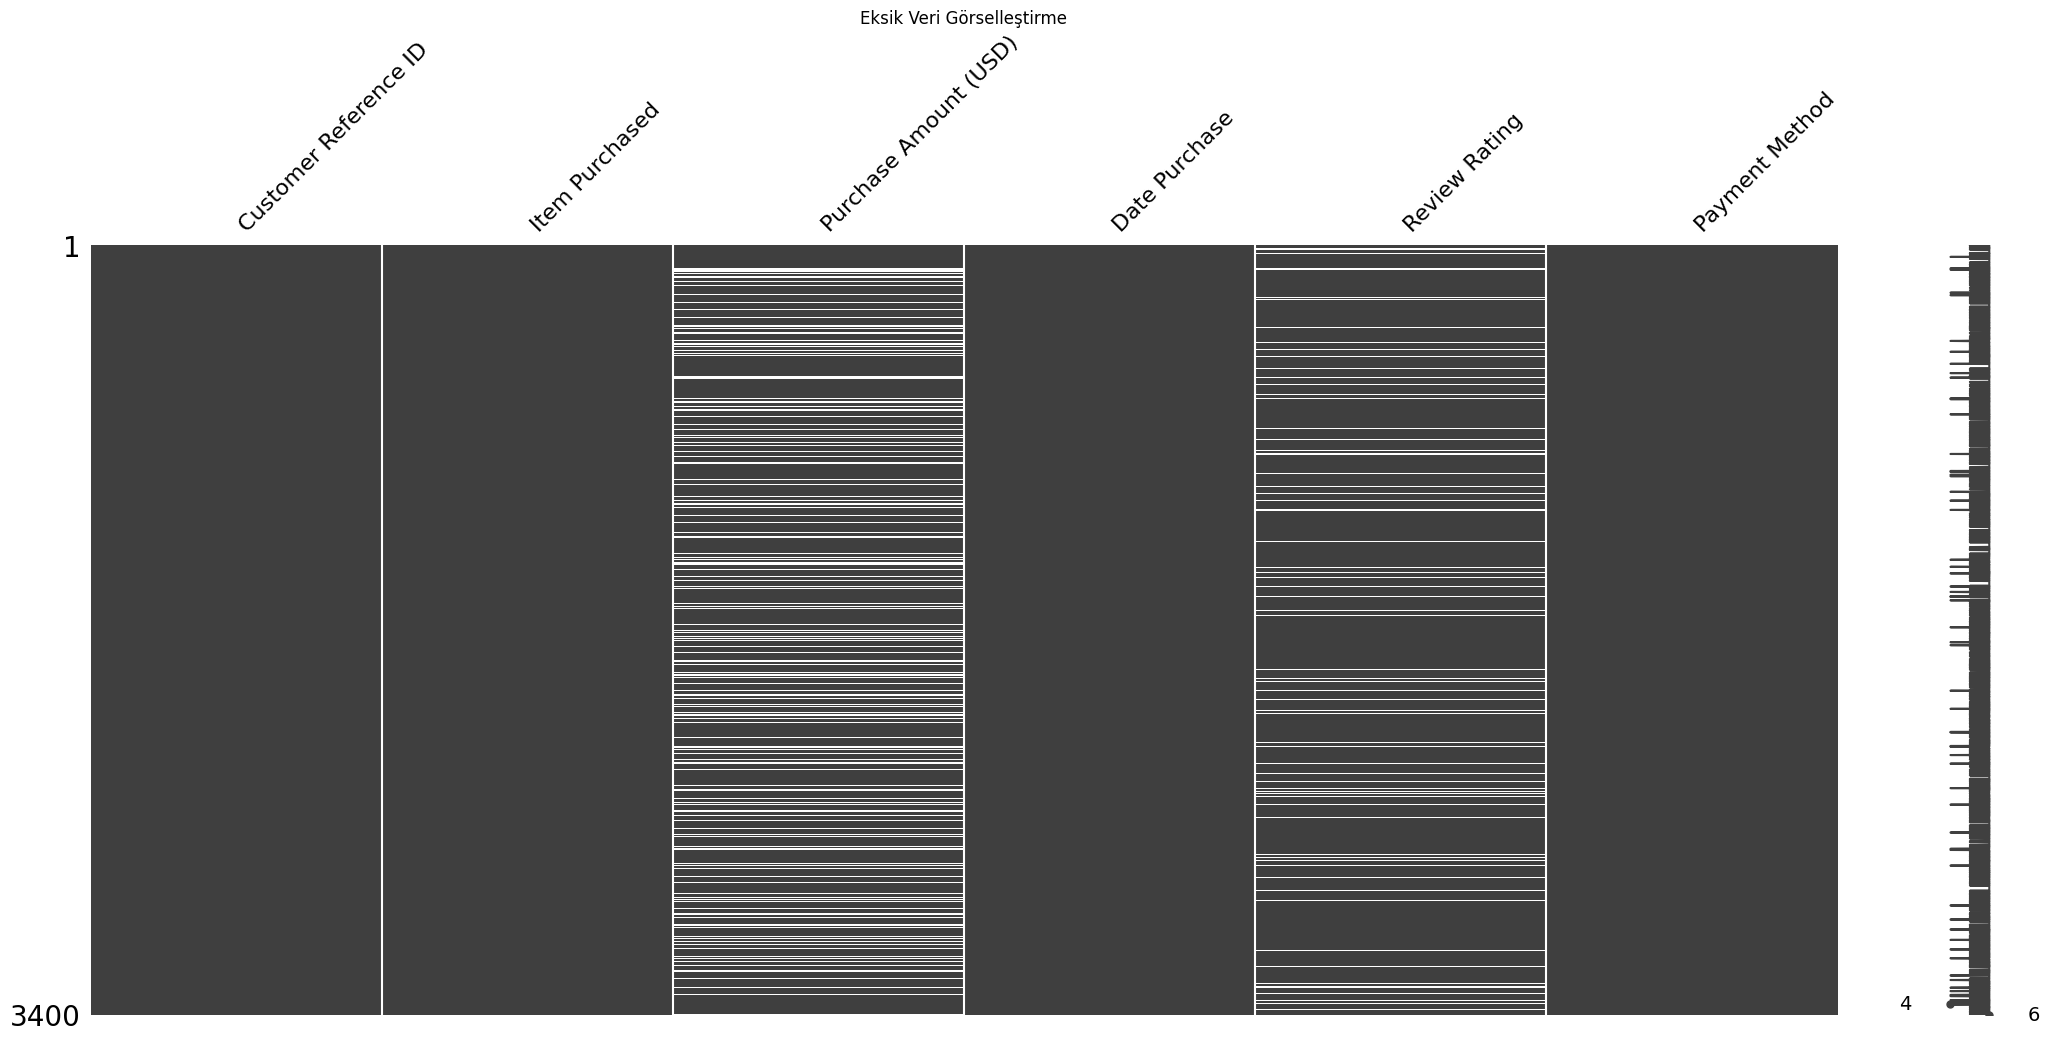

In [5]:
# ✅ Eksik veri analizi (missingno)
msno.matrix(df)
plt.title("Eksik Veri Görselleştirme")
plt.show()

In [6]:
# ✅ Tarihi datetime'a çevir
df['Date Purchase'] = pd.to_datetime(df['Date Purchase'], dayfirst=True)

In [7]:
# ✅ Benzersiz değerleri yazdır
print("Satın Alınan Ürünler:", df['Item Purchased'].unique())
print("Ödeme Yöntemleri:", df['Payment Method'].value_counts())

Satın Alınan Ürünler: ['Handbag' 'Tunic' 'Tank Top' 'Leggings' 'Wallet' 'Onesie' 'Jacket'
 'Trousers' 'Jeans' 'Loafers' 'Slippers' 'Bowtie' 'Pajamas' 'Trench Coat'
 'Poncho' 'Gloves' 'Romper' 'T-shirt' 'Flip-Flops' 'Shorts' 'Blazer'
 'Boots' 'Belt' 'Hoodie' 'Sweater' 'Blouse' 'Swimsuit' 'Kimono' 'Cardigan'
 'Socks' 'Pants' 'Scarf' 'Backpack' 'Dress' 'Camisole' 'Sneakers'
 'Flannel Shirt' 'Tie' 'Polo Shirt' 'Umbrella' 'Hat' 'Sun Hat' 'Overalls'
 'Coat' 'Sunglasses' 'Vest' 'Sandals' 'Jumpsuit' 'Raincoat' 'Skirt']
Ödeme Yöntemleri: Payment Method
Credit Card    1770
Cash           1630
Name: count, dtype: int64


In [8]:
# ✅ Kategorik değişkenleri dönüştür (get_dummies)
df = pd.get_dummies(df, columns=['Item Purchased', 'Payment Method'], drop_first=True)

In [9]:
# ✅ Kolon adlarını sadeleştir
df.rename(columns={
    'Purchase Amount (USD)': 'Purchase_Amount',
    'Date Purchase': 'Date_Purchase',
    'Review Rating': 'Rating'
}, inplace=True)

In [10]:
# ✅ Ortalama üzeri satışlar için yeni kolon (np.where)
df['Purchase_Amount'] = df['Purchase_Amount'].fillna(df['Purchase_Amount'].mean())

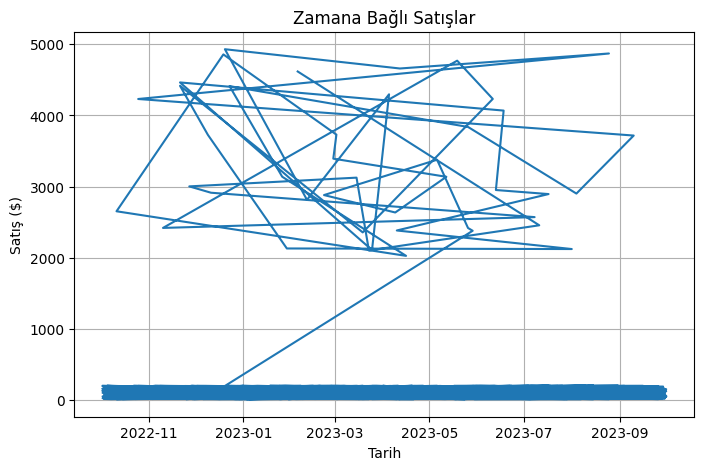

In [11]:
# ✅ Zaman serisi satış grafiği
plt.figure(figsize=(8,5))
plt.plot(df['Date_Purchase'], df['Purchase_Amount'])
plt.title("Zamana Bağlı Satışlar")
plt.xlabel("Tarih")
plt.ylabel("Satış ($)")
plt.grid(True)
plt.show()

In [12]:
# Yüksek satış sınıfını belirle (örneğin, ortalama satışın üzerinde veya altında olanlar)
average_sale = df['Purchase_Amount'].mean()

# 'High_Sale' sütununu oluştur
df['High_Sale'] = df['Purchase_Amount'].apply(lambda x: 'High' if x > average_sale else 'Low')

# İlk birkaç satırı kontrol et
print(df.head())

   Customer Reference ID  Purchase_Amount Date_Purchase  Rating  \
0                   4018           4619.0    2023-02-05     NaN   
1                   4115           2456.0    2023-07-11     2.0   
2                   4019           2102.0    2023-03-23     4.1   
3                   4097           3126.0    2023-03-15     3.2   
4                   3997           3003.0    2022-11-27     4.7   

   Item Purchased_Belt  Item Purchased_Blazer  Item Purchased_Blouse  \
0                False                  False                  False   
1                False                  False                  False   
2                False                  False                  False   
3                False                  False                  False   
4                False                  False                  False   

   Item Purchased_Boots  Item Purchased_Bowtie  Item Purchased_Camisole  ...  \
0                 False                  False                    False  ...   
1   

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


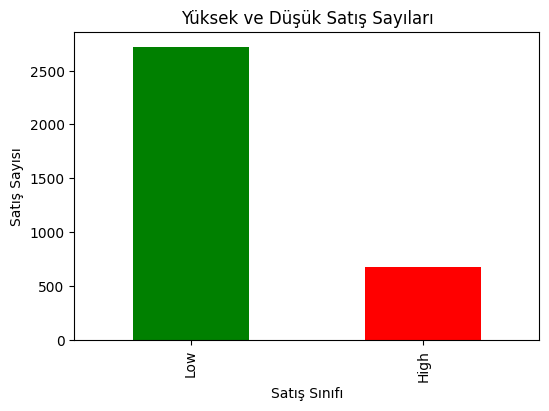

In [13]:
# Satış sınıfları bar chart
plt.figure(figsize=(6,4))
df['High_Sale'].value_counts().plot(kind='bar', color=['green', 'red'])
plt.title("Yüksek ve Düşük Satış Sayıları")
plt.xlabel("Satış Sınıfı")
plt.ylabel("Satış Sayısı")
plt.show()

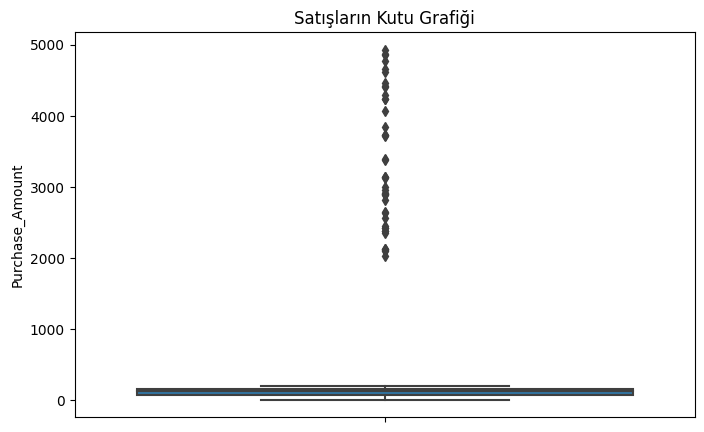

In [14]:
# Satışların boxplot'u
plt.figure(figsize=(8,5))
sns.boxplot(data=df, y='Purchase_Amount')
plt.title("Satışların Kutu Grafiği")
plt.show()

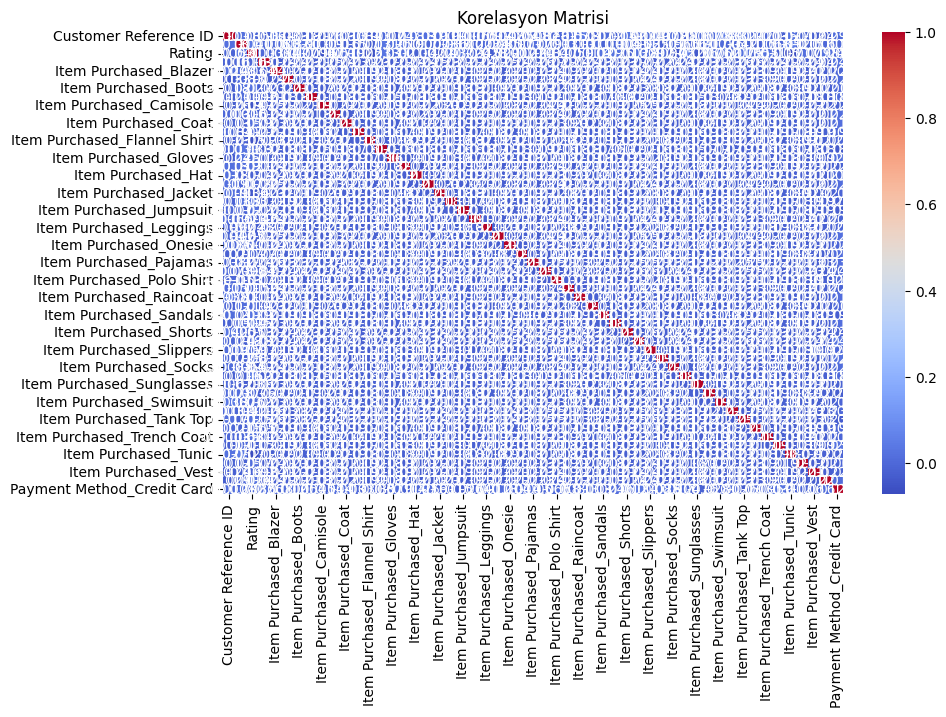

In [15]:
# Korelasyon matrisi
plt.figure(figsize=(10,6))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='coolwarm')
plt.title("Korelasyon Matrisi")
plt.show()

In [16]:
# NaN (eksik) verileri içeren tüm satırları sil
df = df.dropna()

# Eksik veri kontrolü
print(df.isna().sum())  # Kontrol etmek için

Customer Reference ID           0
Purchase_Amount                 0
Date_Purchase                   0
Rating                          0
Item Purchased_Belt             0
Item Purchased_Blazer           0
Item Purchased_Blouse           0
Item Purchased_Boots            0
Item Purchased_Bowtie           0
Item Purchased_Camisole         0
Item Purchased_Cardigan         0
Item Purchased_Coat             0
Item Purchased_Dress            0
Item Purchased_Flannel Shirt    0
Item Purchased_Flip-Flops       0
Item Purchased_Gloves           0
Item Purchased_Handbag          0
Item Purchased_Hat              0
Item Purchased_Hoodie           0
Item Purchased_Jacket           0
Item Purchased_Jeans            0
Item Purchased_Jumpsuit         0
Item Purchased_Kimono           0
Item Purchased_Leggings         0
Item Purchased_Loafers          0
Item Purchased_Onesie           0
Item Purchased_Overalls         0
Item Purchased_Pajamas          0
Item Purchased_Pants            0
Item Purchased

In [17]:
# REGRESSION (Linear Regression)
# X ve y oluştur
X_reg = df.drop(columns=['Customer Reference ID', 'Purchase_Amount', 'Date_Purchase', 'High_Sale'])
y_reg = df['Purchase_Amount']

# Eğitim ve test verilerine ayır
X_train, X_test, y_train, y_test = train_test_split(X_reg, y_reg, test_size=0.2, random_state=42)

# Veriyi standardize et
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Modeli kur ve eğit
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)

# Tahminleri al
y_pred_lr = lr.predict(X_test_scaled)

# Model değerlendirmesi
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_lr)))

RMSE: 319.5693226705411


In [18]:
# SINIFLANDIRMA (Random Forest)
X_clf = df.drop(columns=['Customer Reference ID', 'High_Sale', 'Date_Purchase', 'Purchase_Amount'])
y_clf = df['High_Sale']

X_train_clf, X_test_clf, y_train_clf, y_test_clf = train_test_split(X_clf, y_clf, test_size=0.2, random_state=42)

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_clf, y_train_clf)
y_pred_rf = rf.predict(X_test_clf)

print("Random Forest Doğruluk:", accuracy_score(y_test_clf, y_pred_rf))
print(classification_report(y_test_clf, y_pred_rf))

Random Forest Doğruluk: 0.737012987012987
              precision    recall  f1-score   support

        High       0.20      0.17      0.18       109
         Low       0.83      0.86      0.84       507

    accuracy                           0.74       616
   macro avg       0.51      0.51      0.51       616
weighted avg       0.72      0.74      0.73       616



10:25:24 - cmdstanpy - INFO - Chain [1] start processing
10:25:24 - cmdstanpy - INFO - Chain [1] done processing


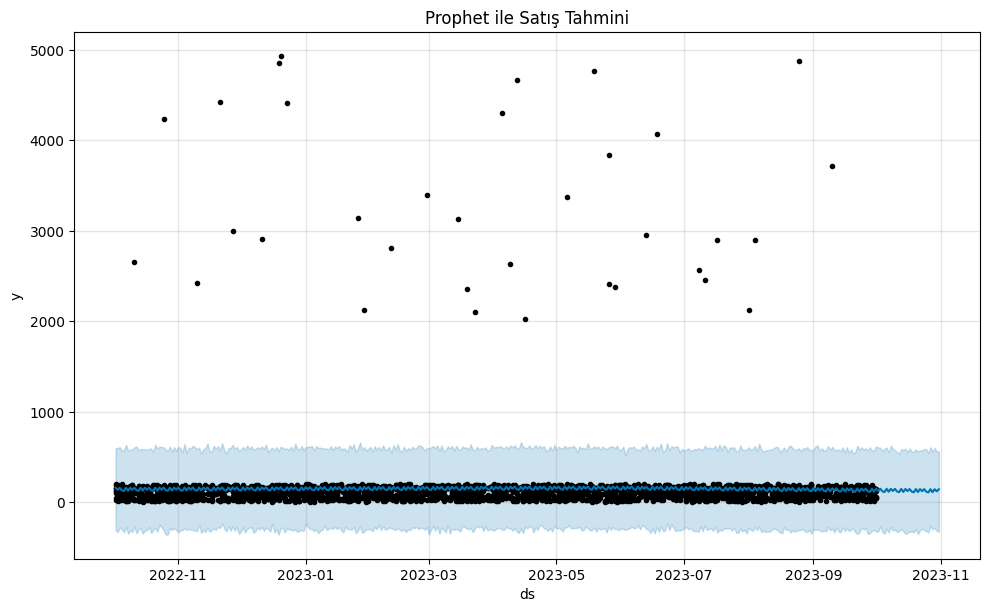

In [19]:
# ZAMAN SERİSİ (Prophet ile Tahmin)
df_prophet = df[['Date_Purchase', 'Purchase_Amount']].rename(columns={
    'Date_Purchase': 'ds',
    'Purchase_Amount': 'y'
})

model = Prophet()
model.fit(df_prophet)

future = model.make_future_dataframe(periods=30)
forecast = model.predict(future)

fig = model.plot(forecast)
plt.title("Prophet ile Satış Tahmini")
plt.show()

In [20]:
# ---------- NETFLIX SHOWS ---------- #

## Netflix Dataset Analizi

Netflix yapımlarına ait meta veriler kullanılarak içerik yapıları analiz edilmiştir.

### Uygulananlar:
- Görselleştirme: Yapım türleri, ülke bazlı dağılımlar, yıllara göre içerik değişimi
- Sınıflandırma: İçerik türüne göre sınıflandırma
- Zaman Serisi Analizi: Yıllara göre içerik çıkış trendleri Prophet modeli ile tahmin edildi

In [21]:
# Veri setini yükle.
net_df = pd.read_csv("/kaggle/input/netflix-shows/netflix_titles.csv")

# Kolon isimlerini kontrol et
print(df.columns)

# Kolon isimlerini temizle (gizli boşluklar ve karakterler)
df.columns = df.columns.str.strip()

Index(['Customer Reference ID', 'Purchase_Amount', 'Date_Purchase', 'Rating',
       'Item Purchased_Belt', 'Item Purchased_Blazer', 'Item Purchased_Blouse',
       'Item Purchased_Boots', 'Item Purchased_Bowtie',
       'Item Purchased_Camisole', 'Item Purchased_Cardigan',
       'Item Purchased_Coat', 'Item Purchased_Dress',
       'Item Purchased_Flannel Shirt', 'Item Purchased_Flip-Flops',
       'Item Purchased_Gloves', 'Item Purchased_Handbag', 'Item Purchased_Hat',
       'Item Purchased_Hoodie', 'Item Purchased_Jacket',
       'Item Purchased_Jeans', 'Item Purchased_Jumpsuit',
       'Item Purchased_Kimono', 'Item Purchased_Leggings',
       'Item Purchased_Loafers', 'Item Purchased_Onesie',
       'Item Purchased_Overalls', 'Item Purchased_Pajamas',
       'Item Purchased_Pants', 'Item Purchased_Polo Shirt',
       'Item Purchased_Poncho', 'Item Purchased_Raincoat',
       'Item Purchased_Romper', 'Item Purchased_Sandals',
       'Item Purchased_Scarf', 'Item Purchased_Shorts'

In [22]:
net_df.info()
net_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8807 entries, 0 to 8806
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   show_id       8807 non-null   object
 1   type          8807 non-null   object
 2   title         8807 non-null   object
 3   director      6173 non-null   object
 4   cast          7982 non-null   object
 5   country       7976 non-null   object
 6   date_added    8797 non-null   object
 7   release_year  8807 non-null   int64 
 8   rating        8803 non-null   object
 9   duration      8804 non-null   object
 10  listed_in     8807 non-null   object
 11  description   8807 non-null   object
dtypes: int64(1), object(11)
memory usage: 825.8+ KB


,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,NaN,United States,"September 25, 2021",2020,PG-13,90 min,Documentaries,"As her father nears the end of his life, filmm..."
1,s2,TV Show,Blood & Water,NaN,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...",South Africa,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, TV Dramas, TV Mysteries","After crossing paths at a party, a Cape Town t..."
2,s3,TV Show,Ganglands,Julien Leclercq,"Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...",NaN,"September 24, 2021",2021,TV-MA,1 Season,"Crime TV Shows, International TV Shows, TV Act...",To protect his family from a powerful drug lor...
3,s4,TV Show,Jailbirds New Orleans,NaN,NaN,NaN,"September 24, 2021",2021,TV-MA,1 Season,"Docuseries, Reality TV","Feuds, flirtations and toilet talk go down amo..."
4,s5,TV Show,Kota Factory,NaN,"Mayur More, Jitendra Kumar, Ranjan Raj, Alam K...",India,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, Romantic TV Shows, TV ...",In a city of coaching centers known to train I...


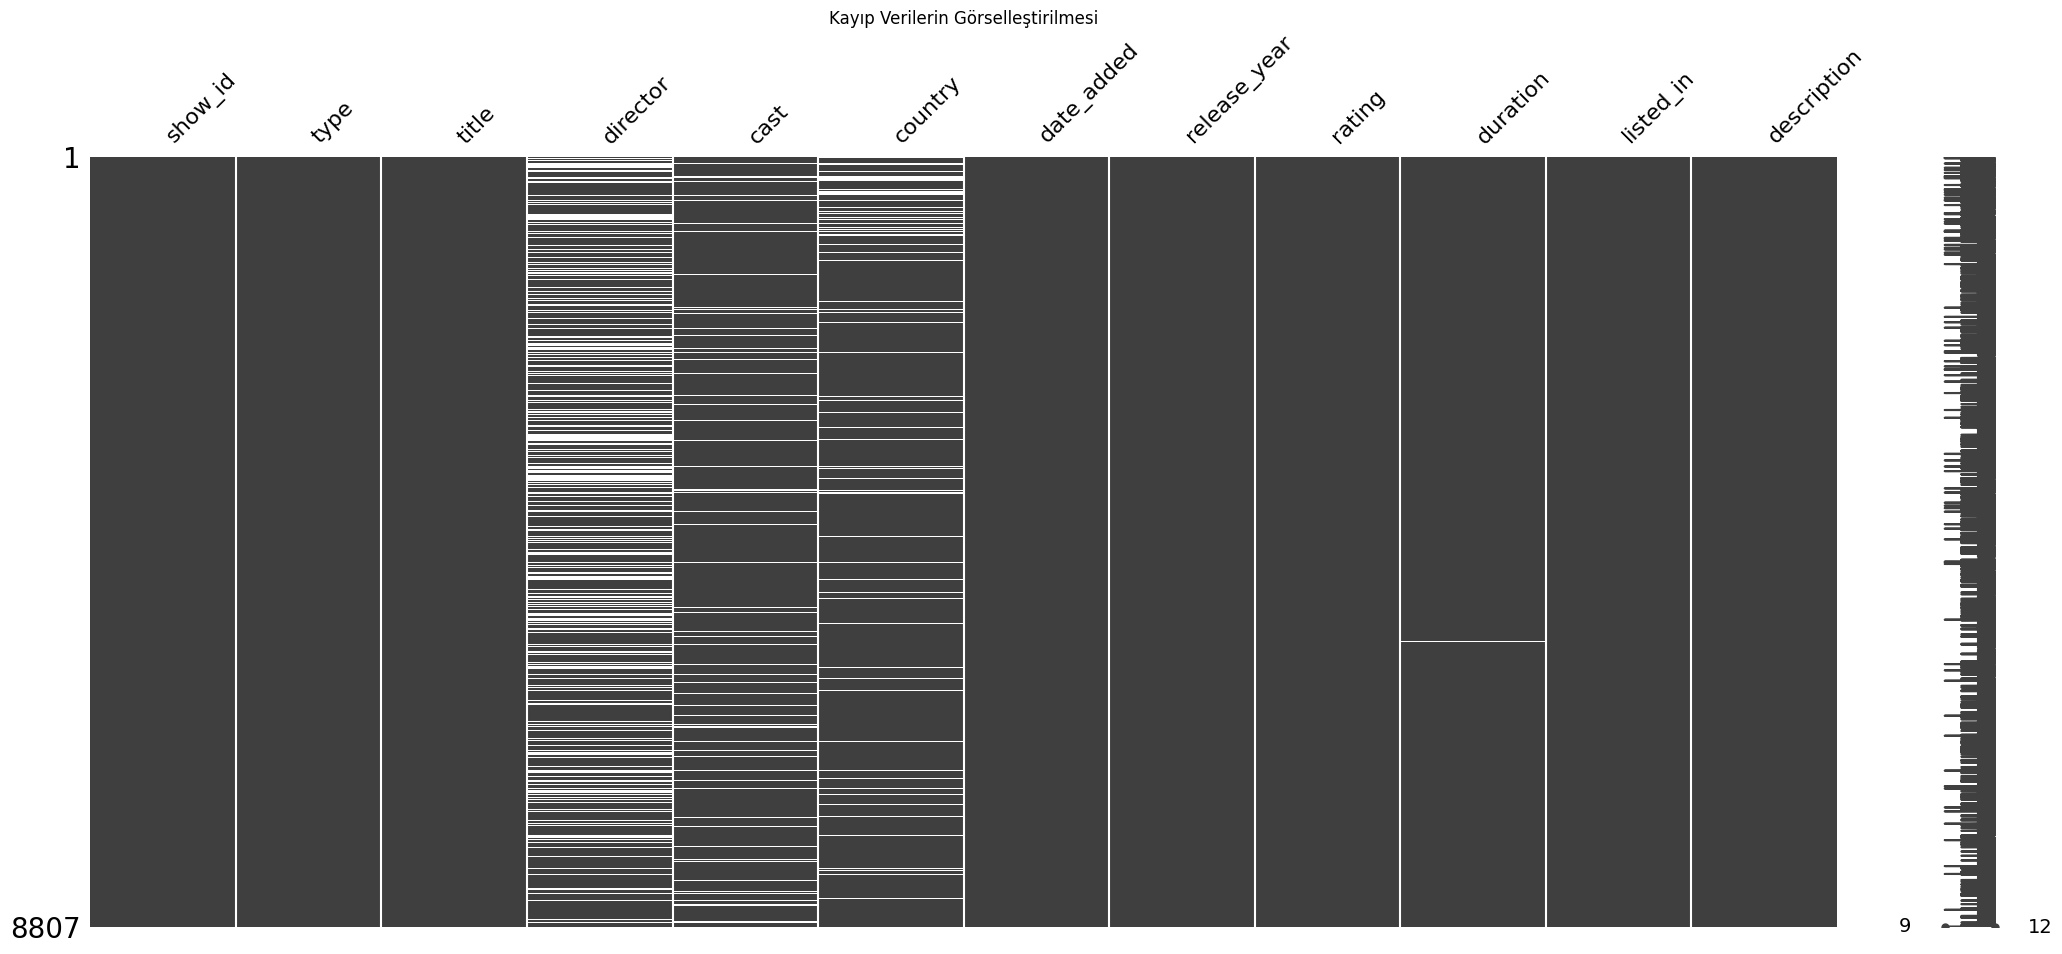

In [23]:
# Kayıp veri analizi (missingno ile)
msno.matrix(net_df)
plt.title("Kayıp Verilerin Görselleştirilmesi")
plt.show()

In [24]:
# Kategorik kolonların benzersiz değerleri
print("Type unique:", net_df['type'].unique())
print("Rating value counts:\n", net_df['rating'].value_counts())


Type unique: ['Movie' 'TV Show']
Rating value counts:
 rating
TV-MA       3207
TV-14       2160
TV-PG        863
R            799
PG-13        490
TV-Y7        334
TV-Y         307
PG           287
TV-G         220
NR            80
G             41
TV-Y7-FV       6
NC-17          3
UR             3
74 min         1
84 min         1
66 min         1
Name: count, dtype: int64


In [25]:
# 'date_added' kolonundaki tarihleri 'coerce' ile dönüştürme
net_df['date_added'] = pd.to_datetime(net_df['date_added'], errors='coerce')

# Dönüştürmeden sonra, NaT (Not a Time) olan verileri kontrol et
print(net_df[net_df['date_added'].isna()])

     show_id     type                                        title  \
6066   s6067  TV Show  A Young Doctor's Notebook and Other Stories   
6079   s6080  TV Show                              Abnormal Summit   
6174   s6175  TV Show              Anthony Bourdain: Parts Unknown   
6177   s6178  TV Show                                     忍者ハットリくん   
6213   s6214  TV Show                                Bad Education   
...      ...      ...                                          ...   
8539   s8540  TV Show                                   The Tudors   
8557   s8558  TV Show                                The West Wing   
8684   s8685  TV Show                                      Vroomiz   
8712   s8713  TV Show                   Weird Wonders of the World   
8755   s8756  TV Show                            Women Behind Bars   

                     director  \
6066                      NaN   
6079  Jung-ah Im, Seung-uk Jo   
6174                      NaN   
6177                      N

In [26]:
# Yıllara göre içerik sayısını gruplama
net_df['year_added'] = net_df['date_added'].dt.year
content_by_year = net_df.groupby('year_added')['show_id'].count()

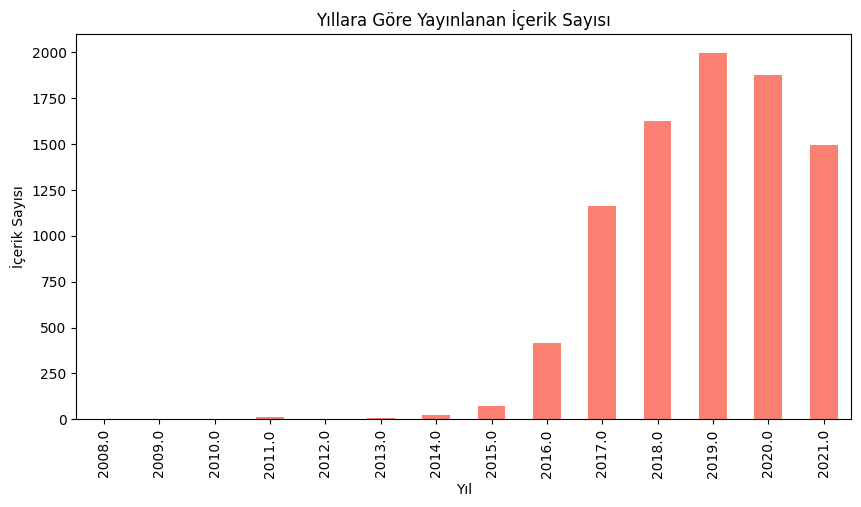

In [27]:
plt.figure(figsize=(10, 5))
content_by_year.plot(kind='bar', color='salmon')
plt.title("Yıllara Göre Yayınlanan İçerik Sayısı")
plt.ylabel("İçerik Sayısı")
plt.xlabel("Yıl")
plt.show()


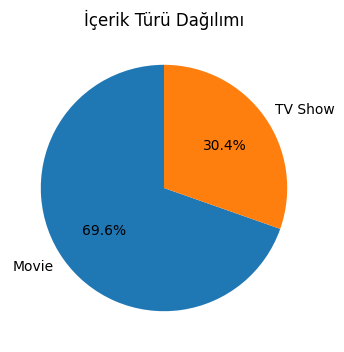

In [28]:
# İçerik türü dağılımı
plt.figure(figsize=(6, 4))
net_df['type'].value_counts().plot.pie(autopct='%1.1f%%', startangle=90)
plt.title("İçerik Türü Dağılımı")
plt.ylabel("")
plt.show()

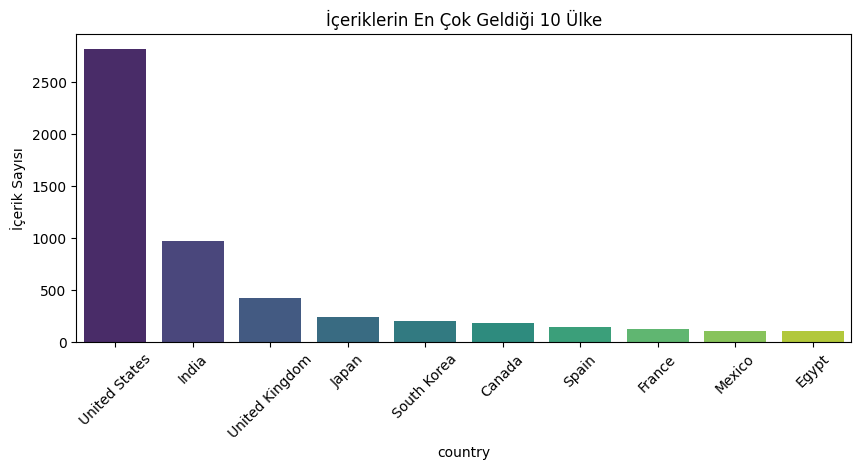

In [29]:
# Ülke dağılımı (ilk 10)
top_countries = net_df['country'].value_counts().head(10)
plt.figure(figsize=(10, 4))
sns.barplot(x=top_countries.index, y=top_countries.values, palette='viridis')
plt.title("İçeriklerin En Çok Geldiği 10 Ülke")
plt.xticks(rotation=45)
plt.ylabel("İçerik Sayısı")
plt.show()

In [30]:
# Dummy variable (type kolonunu dönüştürüyoruz)
net_df = pd.get_dummies(net_df, columns=['type'], drop_first=True)

In [31]:
# Rating kolonunu basitleştirme: np.where
net_df['is_mature'] = np.where(net_df['rating'].isin(['TV-MA', 'R', 'NC-17']), 1, 0)

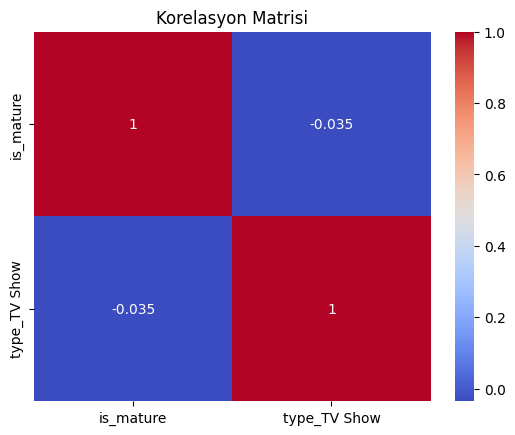

In [32]:
# Korelasyon Matrisi 
corr_matrix = net_df[['is_mature', 'type_TV Show']].corr()

# Korelasyon matrisini görselleştir
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title("Korelasyon Matrisi")
plt.show()

In [33]:
# Sadece filmleri al
movies_df = net_df[net_df['type_TV Show'] == 0].copy()

# Süreyi sayıya çevir
movies_df['duration_num'] = movies_df['duration'].str.extract('(\d+)')
movies_df['duration_num'] = pd.to_numeric(movies_df['duration_num'], errors='coerce')

# Gerekli sütunlardan eksikleri at
movies_df = movies_df.dropna(subset=['release_year', 'duration_num'])

# Özellikler ve hedef
X = movies_df[['duration_num']]
y = movies_df['release_year']

# Veriyi ayır
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Ölçekleme
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Model
model = LinearRegression()
model.fit(X_train_scaled, y_train)

# Tahmin
y_pred = model.predict(X_test_scaled)

# Sonuç
print("R2 Score:", r2_score(y_test, y_pred))
print("MSE:", mean_squared_error(y_test, y_pred))

R2 Score: 0.011236806000486155
MSE: 91.76488689755728


In [34]:
# Classification (Random Forest ile)
clf_df = net_df[['is_mature', 'type_TV Show']].dropna()  # 'type_Movie' yerine 'type_TV Show'
X = clf_df.drop('is_mature', axis=1)  # Features
y = clf_df['is_mature']  # Target

# Veriyi eğitim ve test olarak ayır
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Modeli oluştur (Random Forest)
clf_model = RandomForestClassifier(n_estimators=100, random_state=42)
clf_model.fit(X_train, y_train)

# Tahmin yap
y_pred = clf_model.predict(X_test)

# Sınıf dağılımını kontrol et
print("Sınıf Dağılımı (Test Seti):")
print(y_test.value_counts())

# Model performansını değerlendir
print("Classification Accuracy:", accuracy_score(y_test, y_pred))

# classification_report'a zero_division parametresi ekle
print("Classification Report:\n", classification_report(y_test, y_pred, zero_division=1))

Sınıf Dağılımı (Test Seti):
is_mature
0    937
1    825
Name: count, dtype: int64
Classification Accuracy: 0.5317820658342792
Classification Report:
               precision    recall  f1-score   support

           0       0.53      1.00      0.69       937
           1       1.00      0.00      0.00       825

    accuracy                           0.53      1762
   macro avg       0.77      0.50      0.35      1762
weighted avg       0.75      0.53      0.37      1762



10:25:28 - cmdstanpy - INFO - Chain [1] start processing
10:25:28 - cmdstanpy - INFO - Chain [1] done processing
/usr/local/lib/python3.11/dist-packages/prophet/forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


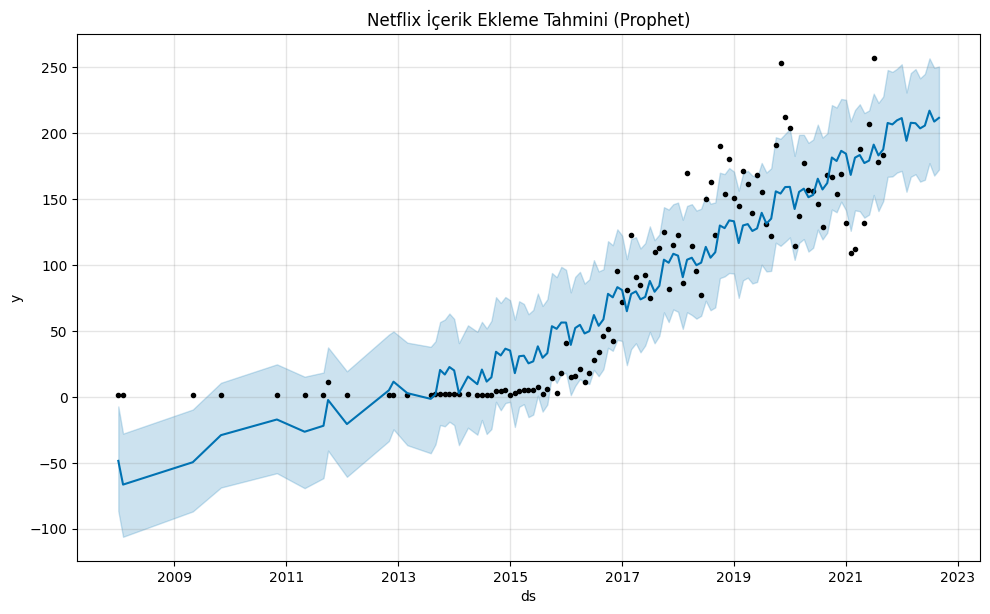

In [35]:
# 'date_added' kolonunun datetime formatına çevrilmesi
net_df['date_added'] = pd.to_datetime(net_df['date_added'], errors='coerce')

# 'date_added' kolonunu ay bazında grupla ve say
date_count = net_df['date_added'].dt.to_period('M').value_counts().sort_index()

# Prophet için uygun veri çerçevesi oluştur
prophet_df = pd.DataFrame({
    'ds': date_count.index.to_timestamp(),  # 'ds' Prophet için tarih sütunu
    'y': date_count.values                   # 'y' ise tahmin edilecek değer
})

# Prophet modelini oluştur
model = Prophet()
model.fit(prophet_df)

# Gelecek 12 ay için tahmin yapımı (sadece periods parametresi geçiyoruz)
future = model.make_future_dataframe(periods=12, freq='M')  # 'prophet_df' zaten model fit edildiği için yalnızca periods kullanıyoruz

# Tahmin yap
forecast = model.predict(future)

# Sonuçları çizdir
fig = model.plot(forecast)
plt.title("Netflix İçerik Ekleme Tahmini (Prophet)")
plt.show()

In [36]:
# --------- TITANIC ---------- # 

## Titanic Dataset Analizi

Titanic veri seti, yolcuların hayatta kalıp kalmayacağını tahmin etmek için kullanılmıştır.

### Uygulananlar:
- Sınıflandırma: RandomForestClassifier ile hayatta kalma tahmini
- Görselleştirme: Yaş, cinsiyet, sınıf gibi değişkenlerin etkisi, korelasyon matrisleri
- Zaman öğesine dayalı analiz: Yolcu sayısındaki tarihsel yapılar incelenmiştir

In [37]:
# dataset import 
tit_df = pd.read_csv('/kaggle/input/test-file/tested.csv')

In [38]:
# İlk birkaç satır
print(tit_df.head())

# Bilgi
tit_df.info()

   PassengerId  Survived  Pclass  \
0          892         0       3   
1          893         1       3   
2          894         0       2   
3          895         0       3   
4          896         1       3   

                                           Name     Sex   Age  SibSp  Parch  \
0                              Kelly, Mr. James    male  34.5      0      0   
1              Wilkes, Mrs. James (Ellen Needs)  female  47.0      1      0   
2                     Myles, Mr. Thomas Francis    male  62.0      0      0   
3                              Wirz, Mr. Albert    male  27.0      0      0   
4  Hirvonen, Mrs. Alexander (Helga E Lindqvist)  female  22.0      1      1   

    Ticket     Fare Cabin Embarked  
0   330911   7.8292   NaN        Q  
1   363272   7.0000   NaN        S  
2   240276   9.6875   NaN        Q  
3   315154   8.6625   NaN        S  
4  3101298  12.2875   NaN        S  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (

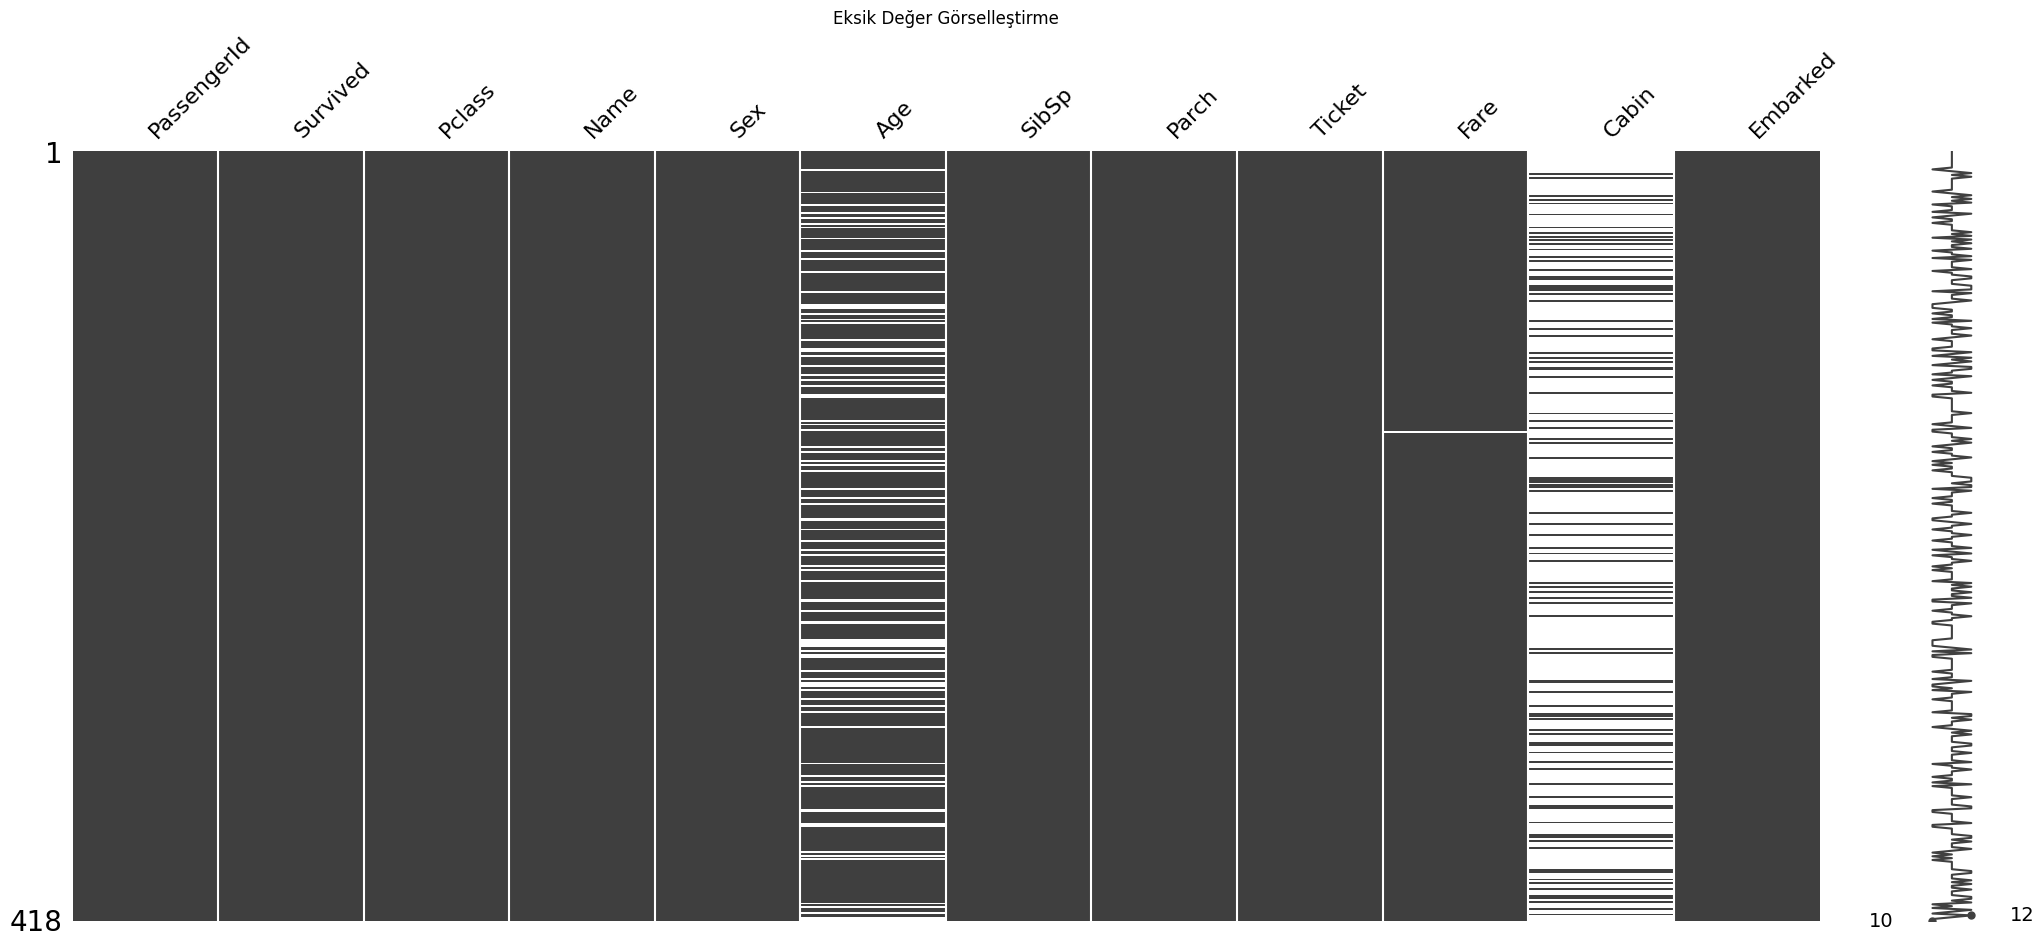

In [39]:
# Eksik değer analizi
msno.matrix(tit_df)
plt.title("Eksik Değer Görselleştirme")
plt.show()

In [40]:
# Kayıp değerlerin toplamı
print(tit_df.isnull().sum())

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64


In [41]:
# Kategorik değişkenleri dummylere çevir
tit_df = pd.get_dummies(tit_df, drop_first=True)

In [42]:
# # Unique ve value_counts sonuçları tablo halinde düzenlemek
output = []

for col in tit_df.columns:
    top_values = tit_df[col].value_counts().head(2)  # İlk 2 değeri al
    # Sadece ilk 2 değeri ve frekansını listeleme
    output.append(f"{col}: {top_values.index[0]} ({top_values.values[0]}), {top_values.index[1]} ({top_values.values[1]})")

# Çıktıyı 3 satır olarak yazdır
print(" | ".join(output[:4]))  # İlk 4 satırı al

PassengerId: 892 (1), 1205 (1) | Survived: 0 (266), 1 (152) | Pclass: 3 (218), 1 (107) | Age: 21.0 (17), 24.0 (17)


Veri Türleri:
PassengerId      int64
Survived         int64
Pclass           int64
Age            float64
SibSp            int64
                ...   
Cabin_F33         bool
Cabin_F4          bool
Cabin_G6          bool
Embarked_Q        bool
Embarked_S        bool
Length: 864, dtype: object


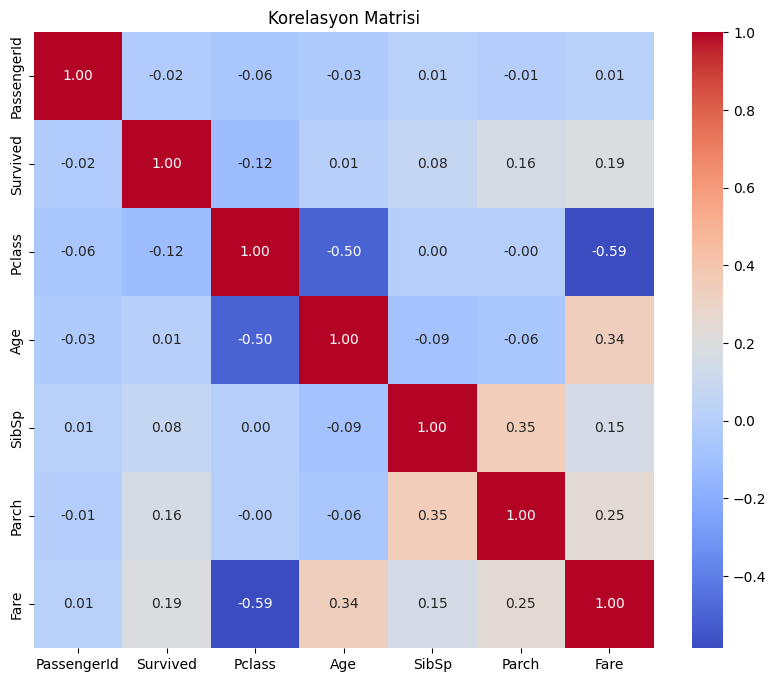

In [43]:
# 1. Veri türlerini kontrol et
print("Veri Türleri:")
print(tit_df.dtypes)

# 2. Sayısal olmayan sütunları çıkar
tit_df_numeric = tit_df.select_dtypes(include=[np.number])

# 3. NaN ve sonsuz değerleri temizle
tit_df_numeric = tit_df_numeric.replace([np.inf, -np.inf], np.nan)  # Sonsuz değerleri NaN'ye dönüştür
tit_df_numeric = tit_df_numeric.dropna()  # NaN değerlerini kaldır

# 4. Korelasyon matrisini hesapla
corr_matrix = tit_df_numeric.corr()

# 5. Korelasyon matrisini görselleştir
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", cbar=True)
plt.title("Korelasyon Matrisi")
plt.show()

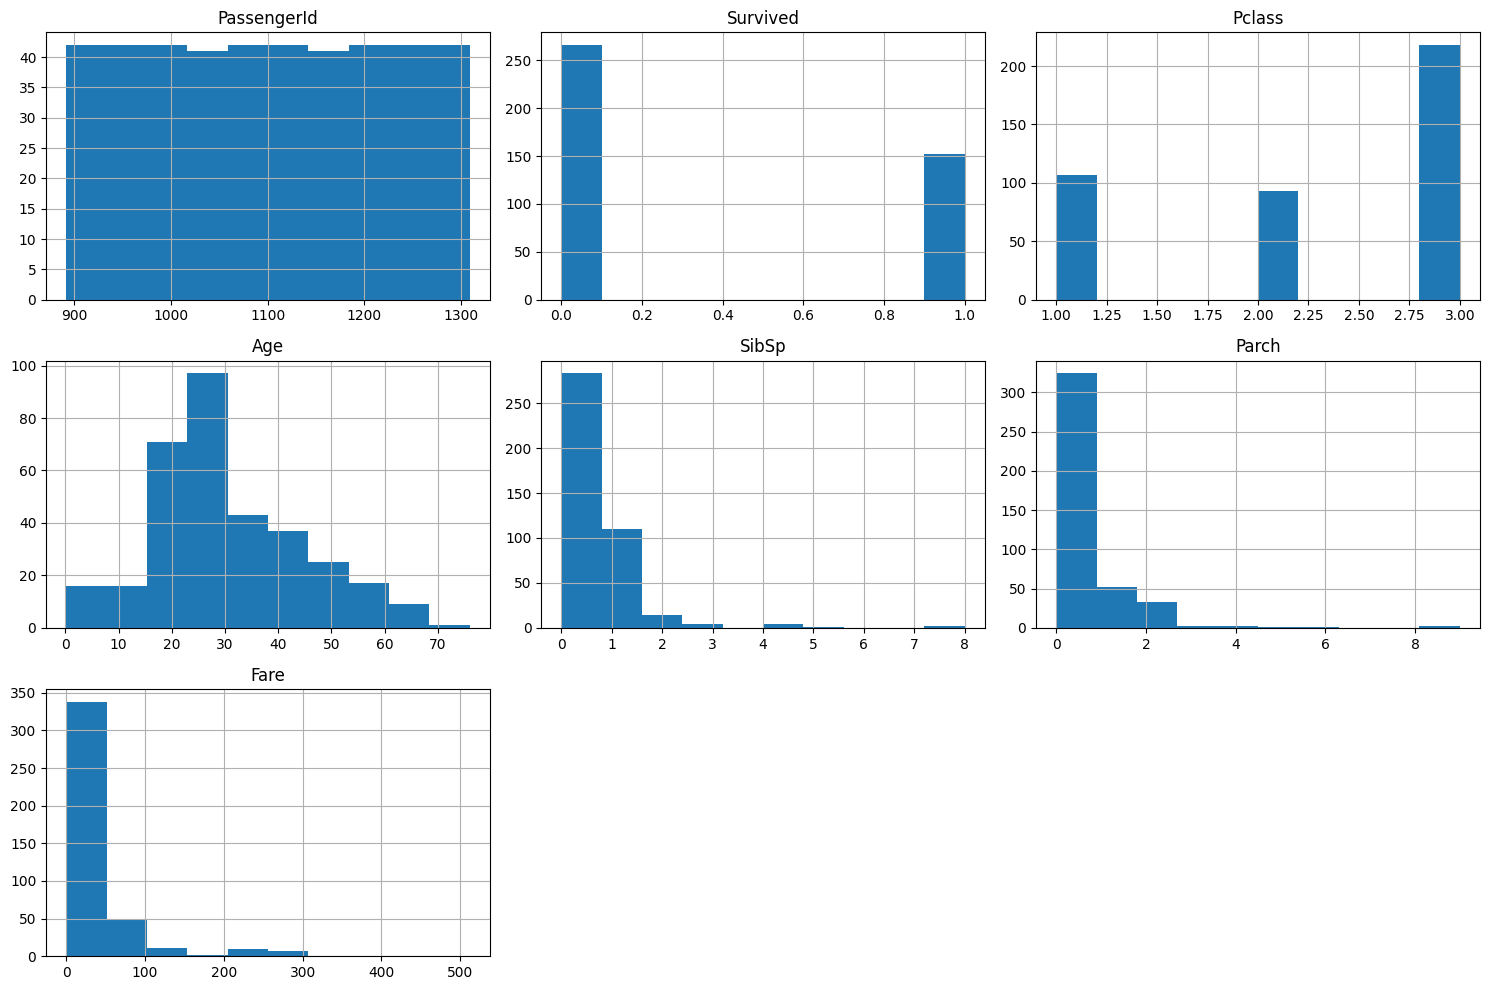

In [44]:
# Histogram
tit_df.hist(figsize=(15,10))
plt.tight_layout()
plt.show()

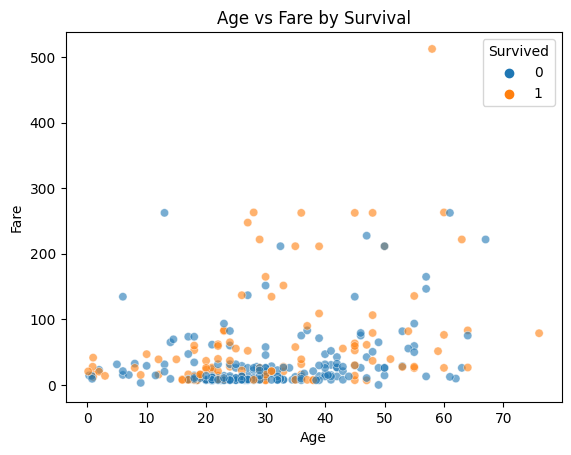

In [45]:
sns.scatterplot(data=tit_df, x='Age', y='Fare', hue='Survived', alpha=0.6)
plt.title('Age vs Fare by Survival')
plt.show()

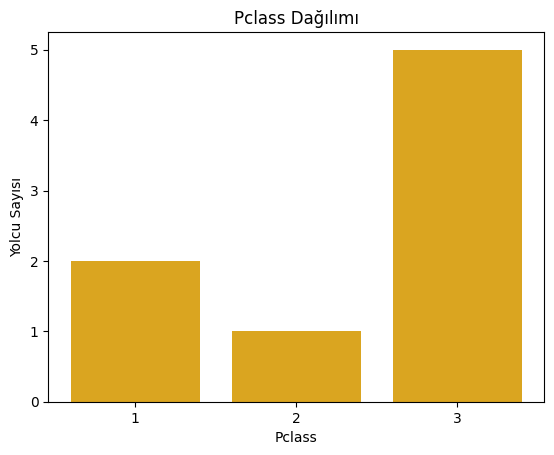

In [46]:
# Küçük örnek alımı
tiny_df = tit_df.sample(frac=0.02, random_state=42)

# Pclass dağılımı (Bar Plot)
pclass_counts = tiny_df['Pclass'].value_counts().sort_index()
plt.bar(pclass_counts.index, pclass_counts.values, color='goldenrod')
plt.title("Pclass Dağılımı")
plt.xlabel("Pclass")
plt.ylabel("Yolcu Sayısı")
plt.xticks([1, 2, 3])
plt.show()

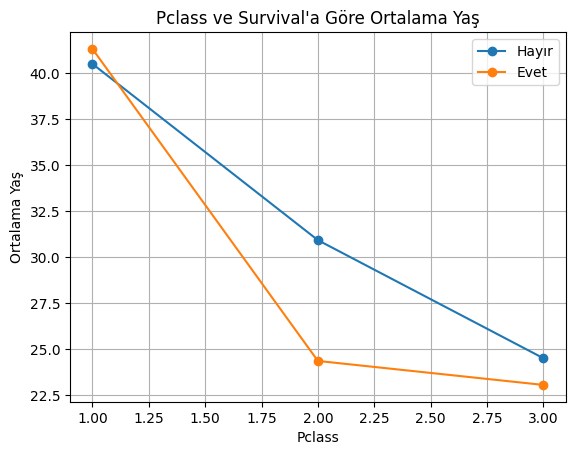

In [47]:
# Survived - Pclass'a göre ortalama yaş (Line Plot)
survived_group = tit_df.groupby(['Pclass', 'Survived'])['Age'].mean().unstack()
survived_group.plot(kind='line', marker='o')
plt.title("Pclass ve Survival'a Göre Ortalama Yaş")
plt.xlabel("Pclass")
plt.ylabel("Ortalama Yaş")
plt.grid(True)
plt.legend(["Hayır", "Evet"])
plt.show()

In [48]:
# REGRESSION "Age" hedefi
# Eksik verileri doldurmak için SimpleImputer kullanımı
imputer = SimpleImputer(strategy='mean')  
tit_df[['Age', 'Fare']] = imputer.fit_transform(tit_df[['Age', 'Fare']])

# Kategorik veriler varsa one-hot encoding yapımı
tit_df = pd.get_dummies(tit_df, drop_first=True)

# Özellik ve hedef belirleme
X = tit_df.drop(columns=['Survived'])
y = tit_df['Fare']  # Burada 'Fare' hedef olarak seçildi, ihtiyaca göre değiştirebilirsiniz

# Train-test ayır
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Ölçekleme
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Model - Linear Regression
lr_model = LinearRegression()
lr_model.fit(X_train_scaled, y_train)

# Tahmin
y_pred = lr_model.predict(X_test_scaled)

# Değerlendirme
print("R2 Score:", r2_score(y_test, y_pred))
print("MSE:", mean_squared_error(y_test, y_pred))

R2 Score: 0.7409643625615173
MSE: 550.7635355075373


In [49]:
# CLASSIFICATION Özellikler ve hedef belirleme
X = tit_df.drop(columns=['Survived'])  # "Survived" dışındaki tüm özellikler
y = tit_df['Survived']

# Train-test ayır
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Ölçekleme
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Random Forest Modelini kur
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_scaled, y_train)

# Tahmin yap
y_pred = rf_model.predict(X_test_scaled)

# Sonuçları değerlendirme
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))

Accuracy: 1.0

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        50
           1       1.00      1.00      1.00        34

    accuracy                           1.00        84
   macro avg       1.00      1.00      1.00        84
weighted avg       1.00      1.00      1.00        84


Confusion Matrix:
 [[50  0]
 [ 0 34]]


10:25:33 - cmdstanpy - INFO - Chain [1] start processing
10:25:33 - cmdstanpy - INFO - Chain [1] done processing


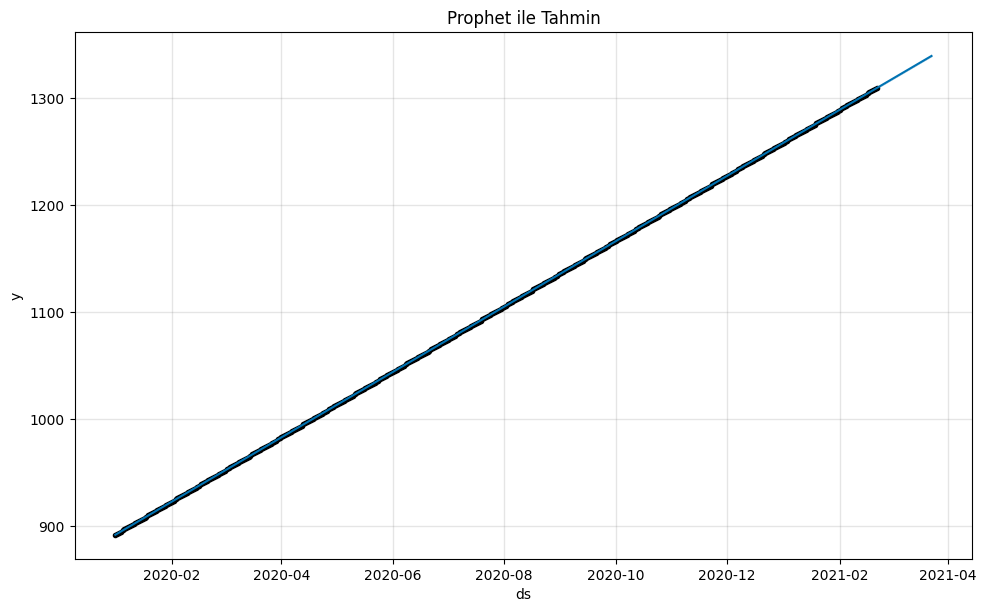

In [50]:
# Prophet modeli için tarih ve değer sütunları gerekiyor. Örnek:
tit_df_prophet = tit_df[[tit_df.columns[0]]].copy()
tit_df_prophet['ds'] = pd.date_range(start='2020-01-01', periods=len(tit_df))
tit_df_prophet.rename(columns={tit_df.columns[0]: 'y'}, inplace=True)

# Model
m = Prophet()
m.fit(tit_df_prophet)

# Gelecek tahmini
future = m.make_future_dataframe(periods=30)
forecast = m.predict(future)

# Tahmin grafiği
fig = m.plot(forecast)
plt.title("Prophet ile Tahmin")
plt.show()

## Sonuçlar

Bu projede her bir veri seti üzerinde:
- Görselleştirme teknikleri (matplotlib, seaborn, missingno)
- Makine öğrenmesi ile sınıflandırma
- Prophet ile zaman serisi tahmini
başarıyla uygulanmıştır.

### Öneriler:
- Deep Learning modelleriyle karşılaştırmalı analiz
- Feature engineering ile doğruluk artışı
- Yeni veri kaynaklarının projeye entegre edilmesi